In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pymc as pm

sys.path.append("../")
import covid19_ode_inference as cov19_ode

/home/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


In [2]:
id_func = lambda x: x
remove_beg_end = lambda x: x[1:-1]
data1 = np.loadtxt("example1.csv", skiprows=1, delimiter=",", converters={0:id_func, 1:remove_beg_end, 2:remove_beg_end})
data2 = np.loadtxt("example1_SIR.csv", skiprows=1, delimiter=",")#, converters={0:id_func, 1:remove_beg_end, 2:remove_beg_end})
N=100_000
cases_data = data1[:, 2]
t_cases_data = np.arange(len(cases_data))
seropos_data = data2[:, 3]/N
t_seropos_data = np.array([1,75,180])
seropos_data_subs = seropos_data[t_seropos_data]
len_sim = len(cases_data)
time=t_cases_data

In [3]:
model = cov19_ode.examples.model_cases_seropositivity(
    N,
    cases_data,
    t_cases_data,
    seropos_data_subs,
    t_seropos_data=t_seropos_data,
    sim_model=False,
    fact_subs=8,
    num_cps_reporting=6,
    num_cps_R = 6,
)

In [4]:

ip = model.initial_point()
logp_fn = model.compile_fn(model.logp(sum=False), mode="JAX")
logp_fn(ip)
dlogp_fn = model.compile_fn(model.dlogp(), mode="JAX")
dlogp_fn(ip)
print("Timing JAX compiled:")
%timeit logp_fn(ip)
%timeit dlogp_fn(ip)

ip = model.initial_point()
logp_fn = model.compile_fn(model.logp(sum=False), mode='FAST_RUN')
logp_fn(ip)
dlogp_fn = model.compile_fn(model.dlogp(), mode='FAST_RUN')
dlogp_fn(ip)
print("Timing C compiled:")
%timeit logp_fn(ip)
%timeit dlogp_fn(ip)
;

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Timing JAX compiled:
353 µs ± 35.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
455 µs ± 30.1 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Timing C compiled:
657 µs ± 36.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.44 ms ± 59 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


''

In [5]:
trace = pm.sample(
    model=model,
    tune=500,
    draws=1000,
    cores=4,
    discard_tuned_samples=False,
    nuts_sampler="numpyro",
    target_accept=0.9,
    nuts_sampler_kwargs=dict(
        chain_method="parallel", 
        nuts_kwargs=dict(max_tree_depth=10, 
                         step_size=1,)
    ),
    keep_warning_stat=True,
)
warnings = pm.stats.convergence.run_convergence_checks(trace,model=model,)
pm.stats.convergence.log_warnings(warnings) 

/home/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/pymc/sampling/mcmc.py:273: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:24.584581
Sampling...


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

Sampling time =  0:06:26.200872
Transforming variables...
Transformation time =  0:00:11.446836


/home/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 40 divergences after tuning. Increase `target_accept` or reparameterize.


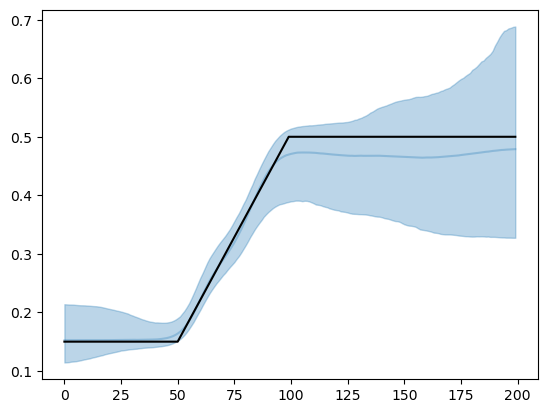

In [6]:
values_inferred = trace.posterior["eta_report"].to_numpy().reshape((-1, len_sim))

plt.plot(time, np.median(values_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.fill_between(time, *np.percentile(values_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(data1[:, 2]/data1[:, 1], color="black")

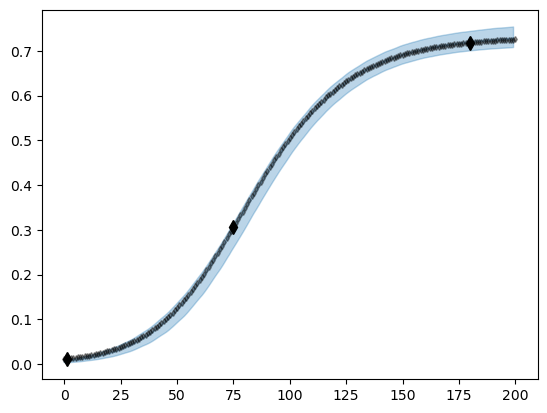

In [7]:
new_positive_inferred = trace.posterior["Sero_t"].to_numpy().reshape((-1, len_sim))

plt.fill_between(time, *np.percentile(new_positive_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(time, np.median(new_positive_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.plot(seropos_data, marker="d", color="black", ls="", ms=3, alpha=0.4);
plt.plot(t_seropos_data, seropos_data[t_seropos_data], marker="d", color="black", ls="", ms=7);



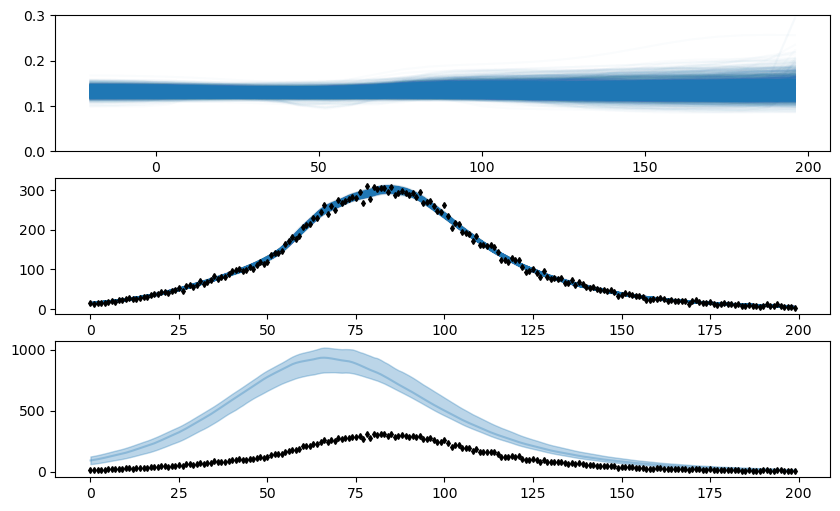

In [8]:
f, axes = plt.subplots(3,1, figsize = (10,6))
t_solve_ODE = model.coords["t_solve_ODE"]
f.sca(axes[0])
plt.plot(t_solve_ODE, trace.posterior["beta_t"].to_numpy().reshape((-1, len(t_solve_ODE))).T, color="tab:blue", alpha = 0.02);
plt.ylim(0,0.3)
f.sca(axes[1])
plt.plot(trace.posterior["new_reported"].to_numpy().reshape((-1, len_sim)).T, color="tab:blue", alpha = 0.02);
plt.plot(cases_data, marker="d", color="black", ls="", ms=3);
f.sca(axes[2])

new_positive_inferred = trace.posterior["new_positive"].to_numpy().reshape((-1, len_sim))
plt.plot(time, np.median(new_positive_inferred, axis=0), color="tab:blue", alpha = 0.3)
plt.fill_between(time, *np.percentile(new_positive_inferred, q=(2.5,97.5), axis=0), color="tab:blue", alpha = 0.3)
plt.plot(cases_data, marker="d", color="black", ls="", ms=3);



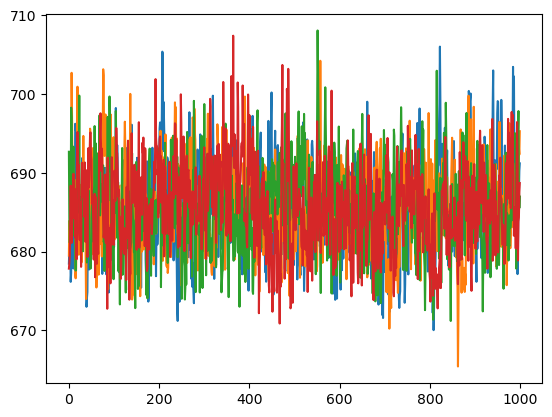

In [9]:
plt.plot(trace.sample_stats["lp"].T)

In [10]:
import arviz as az
rhat = az.rhat(trace)
rhat.max()

/home/jdehning/mambaforge/envs/dev_env/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


<xarray.Dataset>
Dimensions:             ()
Data variables: (12/30)
    eta_base            float64 1.013
    Delta_t_pos_rep     float64 1.063
    Delta_rhos_raw      float64 1.077
    transients_rep_raw  float64 1.019
    Delta_t_pos_R       float64 1.002
    Delta_rhos_R_raw    float64 1.003
    ...                  ...
    S                   float64 1.015
    I                   float64 1.015
    R                   float64 1.014
    new_positive        float64 1.015
    new_reported        float64 1.008
    Sero_t              float64 1.014